# Amazon Video Games Recommendation System

## Business Understanding

In order to enhance the customer’s shopping experience, the online shopping sites usually have their own recommendation system to personalize each customer's shopping experience. Besides,according to [the research on personalization](https://www.accenture.com/_acnmedia/PDF-77/Accenture-Pulse-Survey.pdf) from Accenture, up to 91% of online store customers admit that they are more likely to use a brand that can personalizes their experience, and 98% of eCommerce website owners say that personalization improves their relationships with customers. Same as Amazon, as one of the biggest online retailers, Amazon has large number of products and variety of shopping categories. Hence, recommendation system becomes a powerful tool that can guide customers to the potential products they are looking for in a time saving way. Just like people who want to shop video games on Amazon, a good recommendation system could guide customers to their potentially interested games among thousands of products in a quick and easy way. Besides, Amazon’s variety of product categories can provide customers more than just games, but also accessories. For example, customers may also need a controller or headphone. We could deploy the recommendation system at checkout page as a reminder and motive customers to purchase more. Hence, a great recommendation system could make Amazon to be a one-stop shop for every gamer.

In [2]:
import json
import gzip
import re
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from surprise import Reader, Dataset, accuracy, NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore, SVD, SVDpp
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

## Data Understanding

The data I used for the project is originally from Amazon.com and collected by department of computer science from UCSD. Due to the large size of the datasets, I’m not able to upload my data to this GitHub repository, but [here](https://nijianmo.github.io/amazon/index.html 'link to access data') is the link to access the data I used. There is a empty Data folder in the GitHub repository. To read the data in this notebook, please download the data and put the dataset in the Data folder. The dataset contains user review from May 1996 to Oct 2018 and each item have at least 5 reviews (5-core). Plus, a metadata includes descriptions, price, sales-rank, brand info of video games. (Video Games: 5-core, metadata)

Both datasets are gzip JSON files, need compress them when read the data.

In [3]:
df_review = pd.read_json('Data/Video_Games_5.json.gz', compression='gzip', lines=True)

In [4]:
df_prod = pd.read_json('Data/meta_Video_Games.json.gz', compression='gzip', lines=True)

In [5]:
df_review.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [6]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         497577 non-null  int64 
 1   verified        497577 non-null  bool  
 2   reviewTime      497577 non-null  object
 3   reviewerID      497577 non-null  object
 4   asin            497577 non-null  object
 5   reviewerName    497501 non-null  object
 6   reviewText      497419 non-null  object
 7   summary         497468 non-null  object
 8   unixReviewTime  497577 non-null  int64 
 9   vote            107793 non-null  object
 10  style           289237 non-null  object
 11  image           3634 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 42.2+ MB


In [7]:
df_prod.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Video Games, PC, Games]",,[],,Reversi Sensory Challenger,[],,Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,,,0042000742,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",0078764343,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Video Games, Retro Gaming & Microconsoles, Su...",,[],,street fighter 2 II turbo super nintendo snes ...,[],,Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,,$0.72,0276425316,[],[],NaN
3,"[Video Games, Xbox 360, Accessories, Controlle...",,[MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...,,Xbox 360 MAS STICK,[],,by\n \n MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,,,0324411812,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
4,"[Video Games, PC, Games, </span></span></span>...",,"[Phonics Alive! 3, The Speller teaches student...",,Phonics Alive! 3: The Speller,[],,by\n \n Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,,,0439335310,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [8]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84819 entries, 0 to 84818
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         84819 non-null  object
 1   tech1            84819 non-null  object
 2   description      84819 non-null  object
 3   fit              84819 non-null  object
 4   title            84819 non-null  object
 5   also_buy         84819 non-null  object
 6   tech2            84819 non-null  object
 7   brand            84819 non-null  object
 8   feature          84819 non-null  object
 9   rank             84819 non-null  object
 10  also_view        84819 non-null  object
 11  main_cat         84819 non-null  object
 12  similar_item     84819 non-null  object
 13  date             84819 non-null  object
 14  price            84819 non-null  object
 15  asin             84819 non-null  object
 16  imageURL         84819 non-null  object
 17  imageURLHighRes  84819 non-null

First do some data cleaning on metadata.

In [9]:
df_prod['price'].loc[df_prod['price']==''].shape

(25460,)

In [11]:
# find out if there are any duplicate products
df_prod.loc[df_prod.duplicated(subset=['asin']), :]

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
13214,"[Video Games, Retro Gaming & Microconsoles, Ni...",,"[front label very worn, Slam the pedal to the ...",,Cruis'n USA,"[B00002STGZ, B00002STI2, B00000DMAO, B00000F1G...",,Nintendo,[Nintendo 64 Classic Fun Racing Game],"[>#11,106 in Video Games (See Top 100 in Video...","[B00002STGZ, B00002STI2, B00000DMAX, B00000F1G...",Video Games,,,$12.34,B00000ID60,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}
13215,"[Video Games, Retro Gaming & Microconsoles, Pl...",,[COOL BOARDERS 3 brings the actions and excite...,,Cool Boarders 3,"[B00002STQV, B000034DBX, B0045L3SNQ, B00001QED...",,989 Studios,"[ALL TIME CLASSIC, GREAT BOARDING GAME, GREAT ...","[>#22,481 in Video Games (See Top 100 in Video...","[B00002STQV, B000034DBX, B000051TVF, B00000I1B...",Video Games,,,$16.99,B00000IFKW,[],[],{}
13216,"[Video Games, Retro Gaming & Microconsoles, Pl...",,"[Factory Sealed, What do you get when you have...",,Blast Radius,[B00000IFRG],,Psygnosis,[Factory Sealed],"[>#74,004 in Video Games (See Top 100 in Video...",[],Video Games,,,$14.95,B00000IFKV,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}
13217,"[Video Games, Retro Gaming & Microconsoles, Ni...",,[Mario Party [Japanese Import] for Nintendo 64...,,Mario Party,"[B000046Q7Q, B00000DMAX, B00005AW1W, B00002DHE...",,Nintendo,[Mini Games],"[>#3,000 in Video Games (See Top 100 in Video ...","[B00005AW1W, B00000DMAX, B0795F9PFR, B000046Q7...",Video Games,,,$59.59,B00000IFRI,[],[],{}
13218,"[Video Games, Retro Gaming &amp; Microconsoles...",,"[In Colony Wars: Vengeance, the sequel to Psyg...",,Colony Wars Vengeance,"[B00002SVMG, B00004TTIE, B00002SVMF, B00000IFK...",,Activision,[],"[>#46,355 in Video Games (See Top 100 in Video...","[B00002SVMG, B00004TTIE, B00004XOWT, B0045L3SNQ]",Video Games,,,$9.25,B00000IFRG,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26117,"[Video Games, PC, Games, </span></span></span>...",,[Casino 5 Pack is for fans of casino games who...,,Casino 5 Pack - PC,[],,by\n \n WB Games,"[Choose from Slots, Poker, Video Poker, Keno o...","[>#177,153 in Video Games (See Top 100 in Vide...",[],Video Games,,,\n\t\t ...,B0004F3332,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}
26118,"[Video Games, PC, Games, </span></span></span>...",,[LIKE NEW],,WWE Raw (Jewel Case) - PC,[],,by\n \n THQ,[LIKE NEW],"[>#89,785 in Video Games (See Top 100 in Video...",[],Video Games,,,,B0004M0SDI,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}
26119,"[Video Games, PC, Games]",,[Take your adrenal glands headlong into the wh...,,AMA Superbike [CD],[],,Valuesoft,[PC],"[>#211,978 in Video Games (See Top 100 in Vide...",[],Video Games,,,$24.94,B0005D452G,[],[],{}
26120,"[Video Games, PC, Games]",,"[In the magical kingdom of Daventry, Queen Val...",,King's Quest VII: Princeless Bride,[],,"Sierra On-Line, Inc.",[],"[>#56,983 in Video Games (See Top 100 in Video...","[B0125NDB28, B000AYFPKG, B00164CHN2, B000P0JQF...",Video Games,,,,B0005PHYPO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}


In [14]:
# drop duplicate products 
df_prod.drop_duplicates(subset=['asin'], inplace=True)

In [15]:
# make sure there are no duplicate products
df_prod.loc[df_prod.duplicated(subset=['asin']), :]

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details


Drop unnecessary columns. 

In [16]:
df_prod.drop(['tech1', 'fit', 'tech2', 'date', 'price', 'imageURLHighRes', 'details'], axis=1, inplace=True)

In [19]:
df_prod.head(10)

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
0,"[Video Games, PC, Games]",[],Reversi Sensory Challenger,[],Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,0042000742,[https://images-na.ssl-images-amazon.com/image...
1,"[Video Games, Xbox 360, Games, </span></span><...",[Brand new sealed!],Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,0078764343,[https://images-na.ssl-images-amazon.com/image...
2,"[Video Games, Retro Gaming & Microconsoles, Su...",[],street fighter 2 II turbo super nintendo snes ...,[],Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,0276425316,[]
3,"[Video Games, Xbox 360, Accessories, Controlle...",[MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...,Xbox 360 MAS STICK,[],by\n \n MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,0324411812,[https://images-na.ssl-images-amazon.com/image...
4,"[Video Games, PC, Games, </span></span></span>...","[Phonics Alive! 3, The Speller teaches student...",Phonics Alive! 3: The Speller,[],by\n \n Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,0439335310,[https://images-na.ssl-images-amazon.com/image...
5,"[Video Games, PC, Games, </span></span></span>...",[CD-ROM],Sim City 3000,[],by\n \n Scholastic,[Sim City 3000 CD-ROM],"[>#19,087 in Video Games (See Top 100 in Video...","[B00004T1M7, B00000G16I, B00006GF1U, B0000C0YW...",Video Games,,0439339006,[https://images-na.ssl-images-amazon.com/image...
6,"[Video Games, PC, Games, </span></span></span>...",[],Phonics Alive! 2 The Sound Blender,[],by\n \n Advanced Software Party,[Phonics Alive! 2 The Sound Blender is a new a...,"[>#117,477 in Video Games (See Top 100 in Vide...",[],Video Games,,0439335299,[]
7,"[Video Games, PC, Games, </span></span></span>]",[a scholastic clubs fairs cd rom game],A to Zap,[],by\n \n sunburst,[],"[>#87,937 in Video Games (See Top 100 in Video...",[],Video Games,,0439339960,[https://images-na.ssl-images-amazon.com/image...
8,"[Video Games, PC, Games]",[video game],Need for Speed Porsche Unleashed,[],Electronic Arts,[video game],"[>#51,505 in Video Games (See Top 100 in Video...","[B00004DITL, B000067NP1, B00003W869]",Video Games,,043933702X,[https://images-na.ssl-images-amazon.com/image...
9,"[Video Games, PC, Games, </span></span></span>...",[Grandma Groupers kelp seeds are missing and w...,Freddi Fish and the Case of The Missing Kelp S...,"[B00002S6E5, B000NQI666, B000AQJ4AG, B000FETCF...",by\n \n Humongous Entertainment,"[Like the real world, Freddi Fishs world chang...","[>#58,523 in Video Games (See Top 100 in Video...","[B000FETCF0, B00005BU3M, B00004UCUT, B0009RAVF...",Video Games,,0439339987,[https://images-na.ssl-images-amazon.com/image...


The biggest problem now is the HTMl tags in some of the columns, like '/span', '/n', 'div', etc. Need to take out these tags.

In [20]:
# convert each list in category column into one string
df_prod['category'] = [','.join(map(str, l)) for l in df_prod['category']]

In [21]:
# try replace the HTML tag with empty string
re.sub('</span>', '', df_prod['category'][1])

'Video Games,Xbox 360,Games,'

In [22]:
# create a function removes HTML tages
def remove_tags(string):
    exclusionlist = ['</span>','<b>', '</b>', '<br />', '\n', '/n', '</div>', '<div>', '<DIV>', '</DIV>']
    exclusions = '|'.join(exclusionlist)
    result = re.sub(exclusions, '', string)
    return result

In [23]:
# apply the function and remove all HTML tags in category column
df_prod['category'] = df_prod['category'].apply(lambda x : remove_tags(x))

In [24]:
# do the same on description column
df_prod['description'] = [''.join(map(str, l)) for l in df_prod['category']]

In [25]:
df_prod['description'] = df_prod['description'].apply(lambda x: remove_tags(x))

In [26]:
# strip by and \n in front of brand names
df_prod['brand'] = df_prod['brand'].apply(lambda x: re.sub('by', '', x))
df_prod['brand'] = df_prod['brand'].apply(lambda x: re.sub('\n', '', x))

In [27]:
df_prod

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
0,"Video Games,PC,Games","Video Games,PC,Games",Reversi Sensory Challenger,[],Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,0042000742,[https://images-na.ssl-images-amazon.com/image...
1,"Video Games,Xbox 360,Games,","Video Games,Xbox 360,Games,",Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,0078764343,[https://images-na.ssl-images-amazon.com/image...
2,"Video Games,Retro Gaming & Microconsoles,Super...","Video Games,Retro Gaming & Microconsoles,Super...",street fighter 2 II turbo super nintendo snes ...,[],Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,0276425316,[]
3,"Video Games,Xbox 360,Accessories,Controllers,J...","Video Games,Xbox 360,Accessories,Controllers,J...",Xbox 360 MAS STICK,[],MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,0324411812,[https://images-na.ssl-images-amazon.com/image...
4,"Video Games,PC,Games,,Grades 2-12,Spelling Pro...","Video Games,PC,Games,,Grades 2-12,Spelling Pro...",Phonics Alive! 3: The Speller,[],Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,0439335310,[https://images-na.ssl-images-amazon.com/image...
...,...,...,...,...,...,...,...,...,...,...,...,...
84814,"Video Games,PlayStation Vita,Digital Games & D...","Video Games,PlayStation Vita,Digital Games & D...",Lego Star Wars: The Force Awakens - PS Vita [D...,[],Warner Bros.,[],"[>#74,224 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ1521Y,[]
84815,"Video Games,PlayStation 4,Digital Games & DLC,...","Video Games,PlayStation 4,Digital Games & DLC,...",Lego Star Wars: The Force Awakens Season Pass...,[],Warner Bros.,[DLC Requires base game],"[>#62,150 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ14TTA,[]
84816,"Video Games,PlayStation 4,Digital Games & DLC,...","Video Games,PlayStation 4,Digital Games & DLC,...",The Technomancer - PS4 [Digital Code],[],Focus Home Interactive,[],"[>#94,234 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ14OT0,[https://images-na.ssl-images-amazon.com/image...
84817,"Video Games,Xbox 360,Accessories,","Video Games,Xbox 360,Accessories,","Repair T8 T6 Tools for XBOX One Xbox 360, YTTL...","[B01KBNB7K2, B06X6JSYPC, B01N6Y0Z7W, B06VXD2W5...",YTTL,[If you want to Replacement you Xbox one /360 ...,"[>#16,087 in Video Games (See Top 100 in Video...","[B01KH25ZY6, B00PG8SU26, B07G122BVS, B016XLTQP...",Video Games,,B01HJC33WS,[https://images-na.ssl-images-amazon.com/image...


I noticed some brands' names are called differently, but they should belong to same game publisher. So far, I found EA Games and Ubisoft Entertainment need to be changed to have consistent publisher name.

In [28]:
df_prod['brand'].loc[df_prod['brand']=='EA Games']

5792     EA Games
6796     EA Games
10441    EA Games
10919    EA Games
10938    EA Games
28068    EA Games
Name: brand, dtype: object

In [29]:
df_prod.loc[df_prod['brand']=='Ubisoft Entertainment']

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
61760,"Video Games,Xbox 360,Games","Video Games,Xbox 360,Games",Assassin's Creed Heritage Collection (Includes...,"[B00NGXUBTI, B00M9TD70K, B01DYSRZPM]",Ubisoft Entertainment,"[Includes 5 Games Including: Assassin's Creed,...","[>#37,943 in Video Games (See Top 100 in Video...","[B00NGXUBTI, B00EVWZHLK, B000P46NMK, B01LYGJRV...",Video Games,,B00FOGFOWY,[https://images-na.ssl-images-amazon.com/image...


In [30]:
df_prod['brand'].replace({'EA Games':'Electronic Arts', 'Ubisoft Entertainment':'Ubisoft'}, inplace=True)

In [31]:
df_prod['brand'].value_counts()

                           3617
        Electronic Arts    2139
        Activision         1955
        Nintendo           1616
        Ubisoft            1384
                           ... 
wiisingonline                 1
        XCM Mods              1
        OddMobb               1
Switch Blade                  1
        Badland Games         1
Name: brand, Length: 9194, dtype: int64

In [32]:
# some products do not provide brand name, replace with unknown
df_prod['brand'].replace({'': 'unknown'}, inplace=True)

In [33]:
df_prod['brand'].value_counts()

unknown                    3619
        Electronic Arts    2139
        Activision         1955
        Nintendo           1616
        Ubisoft            1384
                           ... 
wiisingonline                 1
        XCM Mods              1
        OddMobb               1
Switch Blade                  1
        Badland Games         1
Name: brand, Length: 9193, dtype: int64

In [34]:
# strip whitespace at beginning of string
df_prod['brand'] = df_prod['brand'].apply(lambda x: x.lstrip())

In [35]:
# create a dataframe shows number of each brand
brand_count_df = pd.DataFrame(data=df_prod['brand'].value_counts().values, index=df_prod['brand'].value_counts().index, columns=['count'])

In [36]:
brand_count_df.head(10)

,count
unknown,3620
Nintendo,2704
Electronic Arts,2565
Activision,2328
Sony,1727
Ubisoft,1609
Sega,1536
Microsoft,1191
Atari,872
THQ,858


In [37]:
df_prod.loc[df_prod['brand']=='Nintendo']

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
2,"Video Games,Retro Gaming & Microconsoles,Super...","Video Games,Retro Gaming & Microconsoles,Super...",street fighter 2 II turbo super nintendo snes ...,[],Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,0276425316,[]
215,"Video Games,Retro Gaming & Microconsoles,Ninte...","Video Games,Retro Gaming & Microconsoles,Ninte...",Forsaken,"[B00002STGL, B00002STGQ, B00000JMWB, B00000DMB...",Nintendo,[Nintendo],"[>#43,237 in Video Games (See Top 100 in Video...","[B00002STGL, B00000DMAT, B00000DMB3, B00000I1B...",Video Games,,B000006OWT,[]
247,"Video Games,Retro Gaming & Microconsoles,Ninte...","Video Games,Retro Gaming & Microconsoles,Ninte...",1080 Snowboarding,"[B00002STI2, B00001QES1, B000021Y2Z, B00002STH...",Nintendo,[],"[>#7,719 in Video Games (See Top 100 in Video ...","[B00001QES1, B00002STI2, B00000DMAX, B00000F1G...",Video Games,,B00000DMAO,[https://images-na.ssl-images-amazon.com/image...
249,"Video Games,Retro Gaming & Microconsoles,Ninte...","Video Games,Retro Gaming & Microconsoles,Ninte...",Mario Kart 64,"[B00002DHEV, B00000F1GM, B0792NTVZ4, B0793J5C1...",Nintendo,[],[>#891 in Video Games (See Top 100 in Video Ga...,"[B00000F1GM, B00002DHEV, B00004VX12, B00000J2W...",Video Games,,B00000DMAX,[https://images-na.ssl-images-amazon.com/image...
251,"Video Games,Retro Gaming & Microconsoles,Ninte...","Video Games,Retro Gaming & Microconsoles,Ninte...",The Legend of Zelda: Ocarina of Time,"[B00000F1GM, B00002DHEV, B00000DMAX, B00002STE...",Nintendo,[],"[>#1,847 in Video Games (See Top 100 in Video ...","[B00000ID61, B00OVJQD4I, B000JVM256, B00004U1R...",Video Games,,B00000DMB3,[https://images-na.ssl-images-amazon.com/image...
...,...,...,...,...,...,...,...,...,...,...,...,...
84537,"Video Games,Wii U,Games,","Video Games,Wii U,Games,",Nintendo Boo amiibo (SM Series) - Nintendo Wii U,"[B00S7O6RG2, B071K9MZ6P, B071K9MTPY, B01CKH0W9...",Nintendo,[Introducing amiibo: character figures designe...,"[>#8,050 in Video Games (See Top 100 in Video ...","[B00S7O6R9E, B01LC98QJO, B071K9MZ6P, B071K9MTP...",Video Games,,B01H2DKGZQ,[]
84553,"Video Games,Kids & Family,Nintendo 3DS,Games,","Video Games,Kids & Family,Nintendo 3DS,Games,",Mario Party Star Rush - Nintendo 3DS,"[B00CH9253W, B075M5MCDF, B01AC3ZA0Y, B01LDUYTX...",Nintendo,"[Break free of turn order, with all players pl...","[>#4,040 in Video Games (See Top 100 in Video ...","[B075M5MCDF, B0792HGXB8, B00CH9253W, B01AC3ZA0...",Video Games,,B01H3NU4OS,[https://images-na.ssl-images-amazon.com/image...
84561,"Video Games,Wii,","Video Games,Wii,",Nintendo Pokemon Go Plus,"[B07C7K7JGW, B07HNC7JB9, B07C75329M, B07C7L9D9...",Nintendo,[The Pokmon GO Plus is a small device that let...,[>#388 in Video Games (See Top 100 in Video Ga...,"[B071K63M65, B06Y5BTX8L, B071R3P45V, B07C1MCH3...",Video Games,,B01H482N6E,[https://images-na.ssl-images-amazon.com/image...
84671,"Video Games,Kids & Family,Nintendo 3DS,Games","Video Games,Kids & Family,Nintendo 3DS,Games",Beyblade 3DS Japan Import,"[B07JCM53Y5, B07D3J3HJ9, B06Y6LNFRZ, B07H9L6LH...",Nintendo,[],"[>#7,410 in Video Games (See Top 100 in Video ...","[B00CP1QC4K, B00CP1Q9LQ, B0732S9YGW, B07D3J3HJ...",Video Games,,B01HBAUF56,[https://images-na.ssl-images-amazon.com/image...


## Content Based Recommendation System

This method uses only information about the description and attributes of the items. For the content based method, I'm going to use category and brand in product metadata as the attributes of items. 

In [38]:
# string split the category column by comma
df_prod['category'] = df_prod['category'].str.split(',')

In [39]:
df_prod

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,asin,imageURL
0,"[Video Games, PC, Games]","Video Games,PC,Games",Reversi Sensory Challenger,[],Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,0042000742,[https://images-na.ssl-images-amazon.com/image...
1,"[Video Games, Xbox 360, Games, ]","Video Games,Xbox 360,Games,",Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,0078764343,[https://images-na.ssl-images-amazon.com/image...
2,"[Video Games, Retro Gaming & Microconsoles, Su...","Video Games,Retro Gaming & Microconsoles,Super...",street fighter 2 II turbo super nintendo snes ...,[],Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,0276425316,[]
3,"[Video Games, Xbox 360, Accessories, Controlle...","Video Games,Xbox 360,Accessories,Controllers,J...",Xbox 360 MAS STICK,[],MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,0324411812,[https://images-na.ssl-images-amazon.com/image...
4,"[Video Games, PC, Games, , Grades 2-12, Spelli...","Video Games,PC,Games,,Grades 2-12,Spelling Pro...",Phonics Alive! 3: The Speller,[],Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,0439335310,[https://images-na.ssl-images-amazon.com/image...
...,...,...,...,...,...,...,...,...,...,...,...,...
84814,"[Video Games, PlayStation Vita, Digital Games ...","Video Games,PlayStation Vita,Digital Games & D...",Lego Star Wars: The Force Awakens - PS Vita [D...,[],Warner Bros.,[],"[>#74,224 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ1521Y,[]
84815,"[Video Games, PlayStation 4, Digital Games & D...","Video Games,PlayStation 4,Digital Games & DLC,...",Lego Star Wars: The Force Awakens Season Pass...,[],Warner Bros.,[DLC Requires base game],"[>#62,150 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ14TTA,[]
84816,"[Video Games, PlayStation 4, Digital Games & D...","Video Games,PlayStation 4,Digital Games & DLC,...",The Technomancer - PS4 [Digital Code],[],Focus Home Interactive,[],"[>#94,234 in Video Games (See Top 100 in Video...",[],Video Games,,B01HJ14OT0,[https://images-na.ssl-images-amazon.com/image...
84817,"[Video Games, Xbox 360, Accessories, ]","Video Games,Xbox 360,Accessories,","Repair T8 T6 Tools for XBOX One Xbox 360, YTTL...","[B01KBNB7K2, B06X6JSYPC, B01N6Y0Z7W, B06VXD2W5...",YTTL,[If you want to Replacement you Xbox one /360 ...,"[>#16,087 in Video Games (See Top 100 in Video...","[B01KH25ZY6, B00PG8SU26, B07G122BVS, B016XLTQP...",Video Games,,B01HJC33WS,[https://images-na.ssl-images-amazon.com/image...


In [40]:
df_prod.columns

Index(['category', 'description', 'title', 'also_buy', 'brand', 'feature',
       'rank', 'also_view', 'main_cat', 'similar_item', 'asin', 'imageURL'],
      dtype='object')

Try to find some frequent categories except Video Games and Games in catergory column. 

In [41]:
categories_ls = df_prod['category'].to_list()

In [42]:
flatten_ls = []
for ls in categories_ls:
    for element in ls:
        flatten_ls.append(element)
categories = set(flatten_ls)

In [ ]:
# use cloolection.Counter to find number of element in flattern_ls
# count = dict(Counter(flatten_ls))
# can't run, the list is too large 

I need to check the category manually and select several catergories that I think appears most frequently.

In [43]:
flatten_ls.count('Retro Gaming & Microconsoles')

11235

In [44]:
# build a function to check if certain designated category is in the category column. 
def check_cat(row, cat):
    if cat in row['category']:
        return 1
    else:
        return 0

Add several new columns. If the checked category is in category column returns 1 else 0.

In [45]:
df_prod['is_PC'] = df_prod.apply(check_cat, args=(['PC']), axis=1)

In [46]:
df_prod['is_Xbox360'] = df_prod.apply(check_cat, args=(['Xbox 360']), axis=1)

In [47]:
df_prod['is_Xboxone'] = df_prod.apply(check_cat, args=(['Xbox One']), axis=1)

In [48]:
df_prod['is_PS4'] = df_prod.apply(check_cat, args=(['PlayStation 4']), axis=1)

In [49]:
df_prod['is_PS3'] = df_prod.apply(check_cat, args=(['PlayStation 3']), axis=1)

In [50]:
df_prod['is_Wii'] = df_prod.apply(check_cat, args=(['Wii']), axis=1)

In [51]:
df_prod['is_microconsloes'] = df_prod.apply(check_cat, args=(['Retro Gaming & Microconsoles']), axis=1)

In [52]:
df_prod['is_accesssories'] = df_prod.apply(check_cat, args=(['Accessories']), axis=1)

In [53]:
df_prod.columns

Index(['category', 'description', 'title', 'also_buy', 'brand', 'feature',
       'rank', 'also_view', 'main_cat', 'similar_item', 'asin', 'imageURL',
       'is_PC', 'is_Xbox360', 'is_Xboxone', 'is_PS4', 'is_PS3', 'is_Wii',
       'is_microconsloes', 'is_accesssories'],
      dtype='object')

In [54]:
def check_brand(row, brand):
    if brand in row['brand']:
        return 1
    else:
        return 0

In [55]:
df_prod['Nintendo'] = df_prod.apply(check_brand, args=(['Nintendo']), axis=1)

In [56]:
df_prod['Electronic Arts'] = df_prod.apply(check_brand, args=(['Electronic Arts']), axis=1)

In [57]:
df_prod['Activision'] = df_prod.apply(check_brand, args=(['Activision']), axis=1)

In [58]:
df_prod['Sega'] = df_prod.apply(check_brand, args=(['Sega']), axis=1)

In [59]:
df_prod['Sony'] = df_prod.apply(check_brand, args=(['Sony']), axis=1)

In [60]:
df_prod['Ubisoft'] = df_prod.apply(check_brand, args=(['Ubisoft']), axis=1)

In [61]:
df_prod['Microsoft'] = df_prod.apply(check_brand, args=(['Microsoft']), axis=1)

In [62]:
df_prod.head()

,category,description,title,also_buy,brand,feature,rank,also_view,main_cat,similar_item,...,is_Wii,is_microconsloes,is_accesssories,Nintendo,Electronic Arts,Activision,Sega,Sony,Ubisoft,Microsoft
0,"[Video Games, PC, Games]","Video Games,PC,Games",Reversi Sensory Challenger,[],Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,...,0,0,0,0,0,0,0,0,0,0
1,"[Video Games, Xbox 360, Games, ]","Video Games,Xbox 360,Games,",Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,...,0,0,0,0,0,0,0,0,0,0
2,"[Video Games, Retro Gaming & Microconsoles, Su...","Video Games,Retro Gaming & Microconsoles,Super...",street fighter 2 II turbo super nintendo snes ...,[],Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,...,0,1,0,1,0,0,0,0,0,0
3,"[Video Games, Xbox 360, Accessories, Controlle...","Video Games,Xbox 360,Accessories,Controllers,J...",Xbox 360 MAS STICK,[],MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,...,0,0,1,0,0,0,0,0,0,0
4,"[Video Games, PC, Games, , Grades 2-12, Spelli...","Video Games,PC,Games,,Grades 2-12,Spelling Pro...",Phonics Alive! 3: The Speller,[],Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,...,0,0,0,0,0,0,0,0,0,0


In [63]:
# Select the columns that I just created above and make another dataframe for the cosine similarity. 
cat_df = pd.DataFrame(data=df_prod.iloc[:,12:].values, index=df_prod['asin'], columns=df_prod.iloc[:,12:].columns)

In [64]:
cat_df.head()

,is_PC,is_Xbox360,is_Xboxone,is_PS4,is_PS3,is_Wii,is_microconsloes,is_accesssories,Nintendo,Electronic Arts,Activision,Sega,Sony,Ubisoft,Microsoft
asin,,,,,,,,,,,,,,,
0042000742,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0078764343,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
0276425316,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
0324411812,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
0439335310,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
cat_df.shape

(71911, 15)

In [66]:
# build a function to find the cosine similarity between selected item and all the items in the dataset. 
def cos_simi(asin):
    product_matrix = cat_df.loc[asin].values
    cosine_sim = cosine_similarity(cat_df, product_matrix.reshape(1, -1))
    return cosine_sim

In [67]:
# create a dataframe that only contains essential products information
df_just_prod = df_prod[['asin', 'title', 'description', 'brand', 'imageURL']]
df_just_prod.head()

,asin,title,description,brand,imageURL
0,0042000742,Reversi Sensory Challenger,"Video Games,PC,Games",Fidelity Electronics,[https://images-na.ssl-images-amazon.com/image...
1,0078764343,Medal of Honor: Warfighter - Includes Battlefi...,"Video Games,Xbox 360,Games,",EA Games,[https://images-na.ssl-images-amazon.com/image...
2,0276425316,street fighter 2 II turbo super nintendo snes ...,"Video Games,Retro Gaming & Microconsoles,Super...",Nintendo,[]
3,0324411812,Xbox 360 MAS STICK,"Video Games,Xbox 360,Accessories,Controllers,J...",MAS SYSTEMS,[https://images-na.ssl-images-amazon.com/image...
4,0439335310,Phonics Alive! 3: The Speller,"Video Games,PC,Games,,Grades 2-12,Spelling Pro...",Advanced Software Pty. Ltd.,[https://images-na.ssl-images-amazon.com/image...


In [68]:
# build a function returns recommended product based on categories
def give_recommendation(asin, num):
    matrix = cos_simi(asin)
    cos_simi_df = pd.DataFrame(data=matrix, index=df_prod['asin'], columns=['cos_simi'])
    cos_simi_df.drop(labels=asin, inplace=True) # we don't need the selected item shows up in the recommendations
    top_cos = cos_simi_df.sort_values(by='cos_simi', ascending=False).head(num)# The higher the cosine similarity is, the most similar two items are.
    recom_prod = df_just_prod.loc[df_prod['asin'].isin(top_cos.index)]
    return recom_prod

In [70]:
# input product: Mario Kart 64(Retro Gaming & Microconsoles, Nintendo)
recom = give_recommendation('B00000DMAX', 10)
recom

,asin,title,description,brand,imageURL
3740,B000046Q7Q,Mario Party 2,"Video Games,Retro Gaming & Microconsoles,Ninte...",Nintendo,[https://images-na.ssl-images-amazon.com/image...
8061,B000068GV4,The Legend of Zelda: Triforce of the Gods [Nin...,"Video Games,Retro Gaming & Microconsoles,Super...",Nintendo,[https://images-na.ssl-images-amazon.com/image...
9448,B00007KUW5,Rayman 3: Hoodlum Havoc,"Video Games,Retro Gaming & Microconsoles,GameC...",Nintendo,[https://images-na.ssl-images-amazon.com/image...
13134,B0002Z2RUO,NFL Blitz Special Edition,"Video Games,Retro Gaming & Microconsoles,Ninte...",Nintendo,[]
29407,B000B8J7KA,Dr. Mario and Puzzle League,"Video Games,Retro Gaming & Microconsoles,Game ...",Nintendo,[https://images-na.ssl-images-amazon.com/image...
32223,B000GXD2UG,Ready 2 Rumble Boxing,"Video Games,Retro Gaming & Microconsoles,Ninte...",Nintendo,[]
32225,B000GXDEWW,NFL Blitz 2001,"Video Games,Retro Gaming & Microconsoles,Ninte...",Nintendo,[]
32228,B000GYTSPS,Jimmy Connors Tennis-Super Nintendo,"Video Games,Retro Gaming & Microconsoles,Super...",Nintendo,[https://images-na.ssl-images-amazon.com/image...
33031,B000J3O1QM,Super Star Wars Trilogy 3 Game Bundle (Super S...,"Video Games,Retro Gaming & Microconsoles,Super...",Nintendo,[https://images-na.ssl-images-amazon.com/image...
37000,B000Y0J29G,Nail N Scale,"Video Games,Retro Gaming & Microconsoles,Game ...",Nintendo,[]


### Trending Products Recommendation

This is a very simple way to make recommendation. For users who first time shop here, we don't have previouse data for them. The trending products would be a good way to grab users' attention, so that we can collect users' behavior data for the later collaborative filtering method. For this one, the products with top number of rating will be our recommendation. We need to know which products have most number of ratings. The review data will be used.

Next, I'm going to do some data cleaning on review dataset.

In [71]:
df_review.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [72]:
# drop unnecessary columns
df_review.drop(['verified', 'reviewTime', 'reviewerName', 'unixReviewTime', 'vote', 'style', 'image'], axis=1, inplace=True)

In [73]:
df_review.head()

,overall,reviewerID,asin,reviewText,summary
0,5,A1HP7NVNPFMA4N,0700026657,"This game is a bit hard to get the hang of, bu...",but when you do it's great.
1,4,A1JGAP0185YJI6,0700026657,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it"
2,3,A1YJWEXHQBWK2B,0700026657,ok game.,Three Stars
3,2,A2204E1TH211HT,0700026657,"found the game a bit too complicated, not what...",Two Stars
4,5,A2RF5B5H74JLPE,0700026657,"great game, I love it and have played it since...",love this game


In [74]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     497577 non-null  int64 
 1   reviewerID  497577 non-null  object
 2   asin        497577 non-null  object
 3   reviewText  497419 non-null  object
 4   summary     497468 non-null  object
dtypes: int64(1), object(4)
memory usage: 19.0+ MB


In [75]:
df_review['reviewText'].fillna(value='', inplace=True)
df_review['summary'].fillna(value='', inplace=True)

Trending products are the products with highest number of rating. 

In [76]:
# most rated products
ratings_prod_summary = df_review.groupby('asin')['overall'].agg(['count', 'mean', 'std'])
most_rated = ratings_prod_summary.sort_values(by='count', ascending=False)
most_rated.head(10)

,count,mean,std
asin,,,
B00178630A,1381,2.824765,1.650119
B000ZK9QCS,905,4.627624,0.814355
B000XJNTNS,834,4.631894,0.794634
B00JK00S0S,783,4.690932,0.863590
B000ZKA0J6,774,3.560724,1.548962
B0012N94WO,726,4.174931,1.100961
B003ZSP0WW,694,4.651297,0.819684
B00GODZYNA,684,4.644737,0.864690
B000ZK7ZOE,674,4.461424,0.847597


In [77]:
# trending products recommendation
print(f'Top selling and rating products: {most_rated.head(10).index.tolist()}')

Top selling and rating products: ['B00178630A', 'B000ZK9QCS', 'B000XJNTNS', 'B00JK00S0S', 'B000ZKA0J6', 'B0012N94WO', 'B003ZSP0WW', 'B00GODZYNA', 'B000ZK7ZOE', 'B000P46NMA']


In [78]:
# recommended trending products
df_just_prod.loc[df_prod['asin'].isin(most_rated.head(10).index.tolist())]

,asin,title,description,brand,imageURL
34644,B000P46NMA,Assassin's Creed - Playstation 3,"Video Games,PlayStation 3,Games,",Ubisoft,[https://images-na.ssl-images-amazon.com/image...
36938,B000XJNTNS,Mario Kart Wii with Wii Wheel,"Video Games,Wii,Accessories,Controllers,Racing...",Nintendo,[https://images-na.ssl-images-amazon.com/image...
37219,B000ZK7ZOE,inFAMOUS - Playstation 3,"Video Games,PlayStation 3,Games,",Sony,[https://images-na.ssl-images-amazon.com/image...
37225,B000ZK9QCS,God of War III - Playstation 3,"Video Games,PlayStation 3,Games,",Sony,[https://images-na.ssl-images-amazon.com/image...
37226,B000ZKA0J6,StarCraft II: Wings of Liberty,"Video Games,PC,Games,",Blizzard Entertainment,[https://images-na.ssl-images-amazon.com/image...
37754,B0012N94WO,Resident Evil 5 - Playstation 3,"Video Games,PlayStation 3,Games,",Capcom,[https://images-na.ssl-images-amazon.com/image...
38709,B00178630A,Diablo III,"Video Games,PC,",Blizzard Entertainment,[https://images-na.ssl-images-amazon.com/image...
47584,B003ZSP0WW,Xbox 360 Wireless Controller - Glossy Black,"Video Games,Xbox 360,Accessories,Controllers,G...",Microsoft,[https://images-na.ssl-images-amazon.com/image...
62781,B00GODZYNA,Uncharted 4: A Thief's End - PlayStation 4,"Video Games,PlayStation 4,Games,",Sony,[https://images-na.ssl-images-amazon.com/image...
65843,B00JK00S0S,The Last of Us Remastered - PlayStation 4,"Video Games,PlayStation 4,Games,",Sony,[https://images-na.ssl-images-amazon.com/image...


## Collaborative Filtering

This method makes automatic predictions about the interests of a user by collecting preferences or taste information from many users. Collaborative filtering tries to predict the rating or preference that a user would give an item based on past ratings and preferences of other users. Collaborative filters do not require item metadata like content based method. 

I'm going to use surprise package to build the model. The dataframe must have three columns, which are user ids, item ids, and the ratings.

In [79]:
surprise_df = df_review[[ 'reviewerID', 'asin', 'overall']]

In [80]:
surprise_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497577 entries, 0 to 497576
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   reviewerID  497577 non-null  object
 1   asin        497577 non-null  object
 2   overall     497577 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 11.4+ MB


Do some DEA

In [81]:
surprise_df.describe()['overall']

count    497577.000000
mean          4.220456
std           1.185424
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [82]:
print('Minimum rating is: %d' %(surprise_df.overall.min()))
print('Maximum rating is: %d' %(surprise_df.overall.max()))

Minimum rating is: 1
Maximum rating is: 5


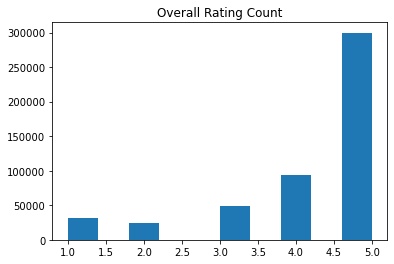

In [83]:
plt.hist(surprise_df['overall'])
plt.title('Overall Rating Count');

In [84]:
percentage_5_rating = len(surprise_df.loc[surprise_df['overall']==5])/len(surprise_df)
print(f'5 star rating takes {round(percentage_5_rating*100,2)}% of overall dataset')

5 star rating takes 60.24% of overall dataset


From the bar chart above, the rating skew to 5.

In [85]:
surprise_df['asin'].value_counts()

B00178630A    1381
B000ZK9QCS     905
B000XJNTNS     834
B00JK00S0S     783
B000ZKA0J6     774
              ... 
B000XJD33E       1
B000WZ7OD4       1
B000WKW6AU       1
B000W2UJ2A       1
B000WMJM3W       1
Name: asin, Length: 17408, dtype: int64

### Baseline

First, let's build some basic models. Surprise has two basic model NormalPredictor and BaselineOnly. I will use them for comparing accuracy with other complex models.

In [86]:
read = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(surprise_df, read)
train_df, test_df = train_test_split(surprise_data, random_state=42)

In [87]:
train_df

In [88]:
baseline_model1 = NormalPredictor()
baseline_model1.fit(train_df)

In [89]:
prediction_normal = baseline_model1.test(test_df)

In [90]:
normal_rmse = accuracy.rmse(prediction_normal)
normal_rmse

RMSE: 1.5190


1.5190248270213067

In [91]:
baseline_model2 = BaselineOnly()
baseline_model2.fit(train_df)

Estimating biases using als...


In [92]:
predictions_base = baseline_model2.test(test_df)

In [93]:
base_rmse = accuracy.rmse(predictions_base)
base_rmse

RMSE: 1.0447


1.0446509835320532

Next, I will try different algorithms and find the most accurate one.

### KNN

In [94]:
knnbasic_cv = cross_validate(KNNBasic(), surprise_data, cv=5, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [95]:
knnbasic_dict = knnbasic_cv
knnbasic_dict

{'test_rmse': array([1.18374619, 1.17799345, 1.18005914, 1.18023908, 1.18502198]),
 'test_mae': array([0.80898971, 0.80624002, 0.80798801, 0.80715806, 0.8100332 ]),
 'fit_time': (48.00317049026489,
  79.87829184532166,
  86.05150103569031,
  82.14145922660828,
  75.31040906906128),
 'test_time': (6.968467950820923,
  7.4912109375,
  7.66412615776062,
  7.707806587219238,
  7.363893747329712)}

In [96]:
knnbasic_best = min(knnbasic_dict['test_rmse'])
print(f'the best KNNBasic model has rmse: {knnbasic_best}')

the best KNNBasic model has rmse: 1.1779934479299707


In [97]:
knnmeans_cv = cross_validate(KNNWithMeans(), surprise_data, cv=5, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [98]:
knnmeans_dict = knnmeans_cv
knnmeans_dict

{'test_rmse': array([1.08855408, 1.09816965, 1.09491625, 1.09030148, 1.09372347]),
 'test_mae': array([0.72320238, 0.72860988, 0.72799609, 0.7237278 , 0.72869323]),
 'fit_time': (41.95182204246521,
  68.04789733886719,
  77.46433687210083,
  73.34794783592224,
  73.26525044441223),
 'test_time': (7.0508387088775635,
  7.635586977005005,
  7.383756875991821,
  7.174645662307739,
  7.279274225234985)}

In [99]:
knnmeans_best = min(knnmeans_dict['test_rmse'])
print(f'the best KNNWithMeans model has rmse: {knnmeans_best}')

the best KNNWithMeans model has rmse: 1.0885540804787552


In [100]:
knnz_cv = cross_validate(KNNWithZScore(), surprise_data, cv=5, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [101]:
knnz_dict = knnz_cv
knnz_dict

{'test_rmse': array([1.10093385, 1.10412309, 1.10337178, 1.09363455, 1.0970888 ]),
 'test_mae': array([0.72715471, 0.73047486, 0.72659497, 0.72116634, 0.72644432]),
 'fit_time': (45.0013427734375,
  73.2367012500763,
  83.93317437171936,
  71.39763307571411,
  84.78057622909546),
 'test_time': (7.404763698577881,
  8.21261477470398,
  9.606358051300049,
  7.362026691436768,
  7.24772834777832)}

In [102]:
knnz_best = min(knnz_dict['test_rmse'])
print(f'the best KNNWithZScore model has rmse: {knnz_best}')

the best KNNWithZScore model has rmse: 1.0936345510829009


### SVD

In [103]:
# use default hyper parameters
svd = SVD(random_state=42)
svd.fit(train_df)
prediction_svd = svd.test(test_df)
accuracy.rmse(prediction_svd)

RMSE: 1.0152


1.0151596982698952

In [104]:
svd.predict('A1HP7NVNPFMA4N', '0700026657')

Prediction(uid='A1HP7NVNPFMA4N', iid='0700026657', r_ui=None, est=4.454239721476054, details={'was_impossible': False})

Do some grid searches on SVD algorithm 

In [ ]:
param_grid = {'n_factors':[20,50,100,150],'n_epochs':[10,20,30],'biased':[True,False]}
svd_grid_search = GridSearchCV(algo_class=SVD, param_grid=param_grid, measures=['rmse'], cv=5)
result1 = svd_grid_search.fit(surprise_data)

In [ ]:
joblib.dump(svd_grid_search, 'Pickle_Files/svd_grid.pkl')

In [112]:
svd_loaded = joblib.load('Pickle_Files/svd_grid.pkl')

In [113]:
best_svd_algo = svd_loaded.best_estimator['rmse']

In [114]:
svd_loaded.best_params

{'rmse': {'n_factors': 50, 'n_epochs': 30, 'biased': True}}

In [118]:
best_svd_algo.fit(train_df)

In [119]:
predictions = best_svd_algo.test(test_df)
accuracy.rmse(predictions)

RMSE: 1.0040


1.0039933454827177

In [120]:
svd_best_param = SVD(n_factors=50, n_epochs=30, biased='True', random_state=42)
svd_best_param.fit(train_df)

In [121]:
svd_best_param.test(test_df)
predictions1 = svd_best_param.test(test_df)
accuracy.rmse(predictions1)

RMSE: 1.0029


1.0029432416894384

grid search on smaller n_factors and larger n_epochs

In [ ]:
parm_grid = {'n_factors':[2,5,10,20],'n_epochs':[50,70,100],'biased':[True,False]}

In [ ]:
svd_grid_search2 = GridSearchCV(algo_class=SVD,param_grid=parm_grid,measures=['rmse'],cv=5)
result2 = svd_grid_search2.fit(surprise_data)

In [ ]:
joblib.dump(svd_grid_search2, 'Pickle_Files/svd_grid_nfactor.pkl')

In [122]:
svd_loaded2 = joblib.load('Pickle_Files/svd_grid_nfactor.pkl')

In [123]:
svd_loaded2.best_params

{'rmse': {'n_factors': 20, 'n_epochs': 50, 'biased': True}}

In [124]:
svd_best_param2 = SVD(n_factors=20, n_epochs=50, biased='True', random_state=42)
svd_best_param2.fit(train_df)

In [125]:
svd_best_param2.test(test_df)
predictions2 = svd_best_param2.test(test_df)
accuracy.rmse(predictions2)

RMSE: 1.0055


1.0054501834755718

grid search learning rate

In [ ]:
param_grid = {'n_factors':[20,50,100,150], 'n_epochs':[10,20,30], 'lr_all':[0.003,0.005,0.01,0.02]}

In [ ]:
svd_grid_search3 = GridSearchCV(algo_class=SVD, param_grid=param_grid, measures=['rmse'], cv=5)
result3 = svd_grid_search3.fit(surprise_data)

In [ ]:
joblib.dump(svd_grid_search3, 'Pickle_Files/svd_grid_lr.pkl')

In [126]:
svd_loaded3 = joblib.load('Pickle_Files/svd_grid_lr.pkl')

In [127]:
svd_loaded3.best_params

{'rmse': {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.02}}

In [128]:
svd_best_param3 = SVD(n_factors=150, n_epochs=30, biased='True', lr_all=0.02, random_state=42)
svd_best_param3.fit(train_df)

In [129]:
svd_best_param3.test(test_df)
predictions3 = svd_best_param3.test(test_df)
accuracy.rmse(predictions3)

RMSE: 0.9981


0.9981241292377293

In [130]:
svd_best = min([accuracy.rmse(prediction_svd), accuracy.rmse(predictions), accuracy.rmse(predictions2), accuracy.rmse(predictions3)])
print(f'the best SVD model has rmse: {svd_best}')

RMSE: 1.0152
RMSE: 1.0040
RMSE: 1.0055
RMSE: 0.9981
the best SVD model has rmse: 0.9981241292377293


### SVDpp

In [131]:
# use default hyper parameters
svdpp = SVDpp(random_state=42)
svdpp.fit(train_df)
predictions_def = svdpp.test(test_df)
accuracy.rmse(predictions_def)

RMSE: 1.0074


1.0073771519138817

In [ ]:
joblib.dump(predictions_def, 'svdpp_def.pkl')

In [133]:
svdpp_def_loaded = joblib.load('Pickle_Files/svdpp_def.pkl')

In [134]:
accuracy.rmse(svdpp_def_loaded)

RMSE: 1.0074


1.0073771519138817

In [ ]:
param_grid = {'n_factors':[20,50], 'n_epochs':[20,50], 'lr_all':[0.005,0.01], 'reg_all':[0.02, 0.05]}
svdpp_grid_search = GridSearchCV(algo_class=SVDpp, param_grid=param_grid, measures=['rmse'], cv=5)
result_svdpp1 = svdpp_grid_search.fit(surprise_data)

I was going to do some grid searches on SVDpp algorithm as well like SVD, but the grid search process takes too long to be finished due to my computer's computational capability. So I will just do some random tuning below and try to get the lowest rmse as I can.

In [135]:
svdpp1 = SVDpp(n_factors=50, n_epochs=50, lr_all=0.005, reg_all=0.005)
svdpp1.fit(train_df)
predictions1 = svdpp1.test(test_df)
accuracy.rmse(predictions1)

RMSE: 1.0355


1.035489515605644

In [ ]:
joblib.dump(predictions1, 'Pickle_Files/svdpp1.pkl')

In [136]:
svdpp1_loaded = joblib.load('Pickle_Files/svdpp1.pkl')

In [137]:
accuracy.rmse(svdpp1_loaded)

RMSE: 1.0329


1.0329479058203719

In [138]:
svdpp2 = SVDpp(n_factors=10, n_epochs=10, lr_all=0.005, reg_all=0.005)
svdpp2.fit(train_df)
predictions2 = svdpp2.test(test_df)
accuracy.rmse(predictions2)

RMSE: 1.0452


1.0452168193643168

In [ ]:
joblib.dump(predictions2, 'Pickle_Files/svdpp2.pkl')

In [ ]:
svdpp2_loaded = joblib.load('Pickle_Files/svdpp2.pkl')

In [ ]:
accuracy.rmse(svdpp2_loaded)

In [ ]:
svdpp3 = SVDpp(n_factors=50, n_epochs=50, lr_all=0.01, reg_all=0.01)
svdpp3.fit(train_df)
predictions3 = svdpp3.test(test_df)
accuracy.rmse(predictions3)

In [ ]:
joblib.dump(predictions3, 'Pickle_Files/svdpp3.pkl')

In [139]:
svdpp3_loaded = joblib.load('Pickle_Files/svdpp3.pkl')

In [140]:
accuracy.rmse(svdpp3_loaded)

RMSE: 1.0270


1.0269838082063034

In [141]:
svdpp_best = min([accuracy.rmse(svdpp_def_loaded), accuracy.rmse(svdpp1_loaded), accuracy.rmse(predictions2), accuracy.rmse(svdpp3_loaded)])
print(f'the best SVDpp model has rmse: {svdpp_best}')

RMSE: 1.0074
RMSE: 1.0329
RMSE: 1.0452
RMSE: 1.0270
the best SVDpp model has rmse: 1.0073771519138817


Make a table and a bar chart shows the lowest rmse for each algorithm

In [142]:
rmse_ls = [normal_rmse, base_rmse, knnbasic_best, knnmeans_best, knnz_best, svd_best, svdpp_best]
algo_rmse_df = pd.DataFrame(data={'algorithm':['NormalPredictor', 'BaselineOnly', 'KNNBasic', 'KNNWithMeans', 'KNNWithZScore', 'SVD', 'SVDpp'],
                                  'rmse':rmse_ls})
algo_rmse_df

,algorithm,rmse
0,NormalPredictor,1.519025
1,BaselineOnly,1.044651
2,KNNBasic,1.177993
3,KNNWithMeans,1.088554
4,KNNWithZScore,1.093635
5,SVD,0.998124
6,SVDpp,1.007377


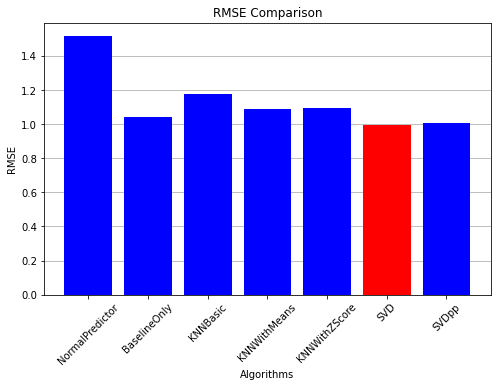

In [143]:
fig, ax = plt.subplots(figsize=(8,5))
color = ['b', 'b', 'b', 'b', 'b', 'r', 'b']
ax.bar(x=algo_rmse_df['algorithm'], height=algo_rmse_df['rmse'], color=color, zorder=2)
ax.grid(axis='y', zorder=0)
plt.xlabel('Algorithms')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.xticks(rotation = 45)
plt.savefig('RMSE Comparison.png', dpi=300, bbox_inches='tight');

We can see that SVD has the lowest rmse, which means in average the predicted rating is the closest to the actual rating. Thus, I will use the best SVD model as my final model to give recommendations.

### The Final Model

In [144]:
# We need to use entire dataset as training data for the final model
trainset_full = surprise_data.build_full_trainset()

In [145]:
best_model = SVD(n_factors=150, n_epochs=30, biased='True', lr_all=0.02, random_state=42)
best_model.fit(trainset_full)

In [151]:
# Users don't want to see the product that they have already rated before
df_rated = pd.DataFrame(df_review.set_index("reviewerID"))
df_rated.head()

,overall,asin,reviewText,summary
reviewerID,,,,
A1HP7NVNPFMA4N,5,0700026657,"This game is a bit hard to get the hang of, bu...",but when you do it's great.
A1JGAP0185YJI6,4,0700026657,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it"
A1YJWEXHQBWK2B,3,0700026657,ok game.,Three Stars
A2204E1TH211HT,2,0700026657,"found the game a bit too complicated, not what...",Two Stars
A2RF5B5H74JLPE,5,0700026657,"great game, I love it and have played it since...",love this game


In [152]:
# build a function that takes in reviewerID and number of recommendation. The fuction returns a table contains all recommended products
def buyer_recommended_products(reviewerID, num): 
    already_reviewed = list(df_rated.loc[reviewerID, 'asin'])
    not_reviewed = df_just_prod.copy()
    not_reviewed = not_reviewed[not_reviewed['asin'].isin(already_reviewed) == False] # only contains not rated products
    not_reviewed.reset_index(inplace=True)
    not_reviewed['predicted_rating'] = not_reviewed['asin'].apply(lambda x: best_model.predict(reviewerID, x).est)
    not_reviewed.sort_values(by='predicted_rating', ascending=False, inplace=True)
    recommended_prod = not_reviewed[['asin','title', 'brand','description', 'imageURL', 'predicted_rating']].head(num)
    return recommended_prod

In [153]:
# Select a random user and get recommendations
recom = buyer_recommended_products('A1JGAP0185YJI6', 10)
recom

,asin,title,brand,description,imageURL,predicted_rating
11175,B0000DJX7I,Grand Theft Auto Double Pack: Grand Theft Auto...,Rockstar Games,"Video Games,Retro Gaming & Microconsoles,Xbox,...",[https://images-na.ssl-images-amazon.com/image...,5.000000
912,B00001XDKO,Unreal Tournament - PC,Atari,"Video Games,PC,Games,",[https://images-na.ssl-images-amazon.com/image...,5.000000
11148,B0000DC64H,Driving Force Wheel for PlayStation 2 and Play...,Logitech,"Video Games,PlayStation 3,Accessories,Controll...",[https://images-na.ssl-images-amazon.com/image...,5.000000
6529,B00005N7YR,Medal of Honor: Allied Assault - PC,Electronic Arts,"Video Games,PC,Games,,Battle in over 20 missio...",[https://images-na.ssl-images-amazon.com/image...,5.000000
16514,B000B9RI14,Xbox 360 LIVE 1600 Points,Microsoft,"Video Games,Xbox One,Currency &amp; Subscripti...",[https://images-na.ssl-images-amazon.com/image...,5.000000
37068,B004XV6ST4,Kinect Sensor TV Mounting Clip - Xbox 360,PDP,"Video Games,Xbox 360,Accessories,Mounts, Brack...",[https://images-na.ssl-images-amazon.com/image...,5.000000
45914,B00CBVHJ00,Thrustmaster HOTAS Warthog Flight Stick PC,ThrustMaster,"Video Games,PC,Accessories,Controllers,Flight ...",[https://images-na.ssl-images-amazon.com/image...,5.000000
3500,B000035Y6D,Super Nintendo Console (SNES System),Nintendo,"Video Games,Retro Gaming &amp; Microconsoles,S...",[https://images-na.ssl-images-amazon.com/image...,4.997846
68232,B01BSQV64I,DOOM [Online Game Code],Bethesda,"Video Games,PC,,Youve come here for a reason. ...",[https://images-na.ssl-images-amazon.com/image...,4.995242
29688,B001REZLY8,Fallout 3: Game of the Year Edition,Bethesda,"Video Games,Xbox 360,",[],4.980431


## Conclusion & Next Steps

In conclusion, trending products recommendation provides a good place to collect new users', so that we could avoid cold start problem. The content based method can filter out customers' potentially interested categories and brand. For the collaborative filtering, the best model is SVD has rmse 0.998, which is a significant drop comparing with baseline models. 

Next steps
- Deploy the recommendation system on the website
- Find a better data, that contains genres of games and more complete brand information. 
- Do web scraping to get most updated data that includes latest video game consles, games and brands. (The current one only contains data from 1996-2018)
- Try the hybrid method.
- Run some AB tests on both new hybrid method and the best model I have.
